In [8]:
import numpy as np
import mindspore as ms
import scipy.io as sio

from mindspore import Tensor
from mindquantum.core.circuit import Circuit, UN            # 导入Circuit模块，用于搭建量子线路
from mindquantum.core.gates import H, X, RX, RY, RZ            # 导入量子门H, RX, RY, RZ
from mindquantum.core.parameterresolver import PRGenerator  # 导入参数生成器模块
from mindquantum.core.operators import QubitOperator
from mindquantum.core.operators import Hamiltonian
from mindquantum.algorithm.nisq import IQPEncoding, Ansatz10
from mindquantum.simulator import Simulator
from mindquantum.framework import MQLayer
from mindspore.nn import Adam, TrainOneStepCell

In [2]:
envir = 'indoor' #'indoor' or 'outdoor'
# image params
img_height = 32
img_width = 32
img_channels = 2
img_total = img_height * img_width * img_channels
img_qubits = np.log2(img_height).astype(int)*2      # 用于编码原始矩阵的量子比特数量

# network params
com_height = 8
com_width = 8                                       # 压缩后，矩阵的高和宽
com_qubits = np.log2(com_width).astype(int)*2       # 用于编码压缩后矩阵的量子比特数量
anc_qubits = 1                                      # 用于 SAWP-TEST 的辅助量子比特
rec_qubits = img_qubits - com_qubits                # 用于恢复原始矩阵的增加的量子比特数量
total_qubits = anc_qubits + img_qubits

encoded_dim = com_height * com_width * img_channels

In [3]:
# 以下 Compressor 是 CsiNet 中左侧压缩图片的神经网络：
class Compressor(ms.nn.Cell):
    def __init__(self, img_channel, img_height, img_width):
        super(Compressor, self).__init__()
        self.img_channel = img_channel
        self.img_height = img_height
        self.img_width = img_width
        self.img_total = img_height*img_width*img_channels

        self.encoded_dim = encoded_dim

        self.conv = ms.nn.Conv2d(
            in_channels = self.img_channel,
            out_channels = 2,
            kernel_size = 3,
            stride = 1,
            pad_mode = 'pad',
            padding = 1,
            has_bias = True
        )

        self.bn = ms.nn.BatchNorm2d(num_features = 2)
        self.leaky_relu = ms.nn.LeakyReLU(alpha = 0.2)
        self.dense_encode = ms.nn.Dense(in_channels=self.img_total, out_channels=encoded_dim)

    def construct(self, x):
        # 第一个黄色箭头
        x = self.conv(x)
        x = self.bn(x)
        x = self.leaky_relu(x)

        # 第一个黑色箭头，Reshape: [N, 2, H, W] --> [N, 2*H*W] == [N, img_total]
        x = x.reshape((x.shape[0], self.img_total))

        # 第一个红色箭头，Dense：[N, img_total] -> [N, encoded_dim]
        encoded = self.dense_encode(x)
        return encoded

In [4]:
# Data loading
if envir == 'indoor':
#    mat = sio.loadmat('../../DataSpace/csinet/data/DATA_Htrainin.mat')
#    x_train = mat['HT'] # array
#    mat = sio.loadmat('../..DataSpace/csinet/data/DATA_Hvalin.mat')
#    x_val = mat['HT'] # array
    mat = sio.loadmat('../../DataSpace/csinet/data/DATA_Htestin.mat')
    x_test = mat['HT'] # array

elif envir == 'outdoor':
    mat = sio.loadmat('../../DataSpace/csinet/data/DATA_Htrainout.mat')
    x_train = mat['HT'] # array
    mat = sio.loadmat('../../DataSpace/csinet/data/DATA_Hvalout.mat')
    x_val = mat['HT'] # array
    mat = sio.loadmat('../../DataSpace/csinet/data/DATA_Htestout.mat')
    x_test = mat['HT'] # array

In [5]:
#x_train = x_train.astype('float32')
#x_val = x_val.astype('float32')
x_test = x_test.astype('float32')
print('shape of x_test:', x_test.shape)

#x_train = np.reshape(x_train, (len(x_train), img_channels, img_height, img_width))  # adapt this if using `channels_first` image data format
#x_val = np.reshape(x_val, (len(x_val), img_channels, img_height, img_width))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), img_channels, img_height, img_width))  # adapt this if using `channels_first` image data format
print('shape of x_test:', x_test.shape)

compressor = Compressor(img_channels, img_height, img_width)
y_test = compressor(Tensor(x_test))  # y_train 是通过无线信道传输到接收端的信号，由量子神经网络进行处理

shape of x_test: (20000, 2048)
shape of x_test: (20000, 2, 32, 32)


In [24]:
x_test[0]

array([[[0.26092365, 0.8519053 , 0.60494775, ..., 0.5064631 ,
         0.50628835, 0.5061246 ],
        [0.53594375, 0.44862032, 0.48540676, ..., 0.49902642,
         0.49905425, 0.4990803 ],
        [0.6845972 , 0.23423736, 0.4227259 , ..., 0.4958728 ,
         0.49600992, 0.49613842],
        ...,
        [0.50568694, 0.49165404, 0.49743164, ..., 0.49995455,
         0.4999586 , 0.4999624 ],
        [0.5052278 , 0.49207103, 0.4973794 , ..., 0.4999839 ,
         0.49998733, 0.49999055],
        [0.5015931 , 0.49639434, 0.4979167 , ..., 0.50014436,
         0.5001438 , 0.50014335]],

       [[0.26467198, 0.85519385, 0.5993463 , ..., 0.5030569 ,
         0.5028804 , 0.502715  ],
        [0.53060496, 0.45449337, 0.4872688 , ..., 0.49964958,
         0.49967253, 0.49969402],
        [0.55893815, 0.41754505, 0.47716975, ..., 0.5001812 ,
         0.5002241 , 0.5002643 ],
        ...,
        [0.49135205, 0.5133076 , 0.5038311 , ..., 0.5002159 ,
         0.5002094 , 0.50020325],
        [0.4

In [6]:
x_test_normalized = np.zeros_like(x_test, dtype=np.float32)
for i in range(x_test.shape[0]):
    real = x_test[i, 0, :, :]
    imag = x_test[i, 1, :, :]
    magnitute = np.sqrt(real**2 + imag**2)
    x_test_normalized[i, 0, :, :] = x_test[i, 0, :, :]/magnitute
    x_test_normalized[i, 1, :, :] = x_test[i, 1, :, :]/magnitute

In [7]:
x_test_normalized[0]

array([[[0.70204616, 0.7057433 , 0.710388  , ..., 0.7094886 ,
         0.70949066, 0.70949256],
        [0.7106374 , 0.70249355, 0.70575184, ..., 0.7066654 ,
         0.7066689 , 0.70667213],
        [0.77461505, 0.48925856, 0.6631142 , ..., 0.70404166,
         0.7041093 , 0.7041728 ],
        ...,
        [0.7171991 , 0.6917104 , 0.70257306, ..., 0.70692205,
         0.7069295 , 0.7069365 ],
        [0.7182519 , 0.68980706, 0.7018441 , ..., 0.7069216 ,
         0.70692956, 0.706937  ],
        [0.7213087 , 0.6846316 , 0.69980085, ..., 0.70695144,
         0.7069606 , 0.7069692 ]],

       [[0.71213144, 0.70846766, 0.7038102 , ..., 0.7047169 ,
         0.7047149 , 0.7047129 ],
        [0.70355844, 0.7116901 , 0.70845914, ..., 0.70754784,
         0.7075444 , 0.7075411 ],
        [0.63243306, 0.8721388 , 0.7485182 , ..., 0.7101587 ,
         0.7100916 , 0.71002865],
        ...,
        [0.69686836, 0.7221749 , 0.7116116 , ..., 0.70729154,
         0.7072841 , 0.707277  ],
        [0.6

In [25]:
y_test[0]

Tensor(shape=[64], dtype=Float32, value= [-1.25390328e-02, -9.79422852e-02, -3.16014066e-02, -7.42473304e-02,  8.90825689e-03, -1.97069228e-01,  7.84911439e-02, -3.01405519e-01,  8.74963403e-02,  1.97433874e-01, -1.85096320e-02,  3.26562345e-01, 
 -2.31146723e-01,  1.56734556e-01, -1.61056966e-01, -2.81586021e-01, -2.77651280e-01, -1.07750349e-01, -1.14025399e-02, -2.15058491e-01, -2.00322688e-01,  8.23833495e-02, -2.11213395e-01,  3.08555394e-01, 
 -1.79063946e-01, -2.16589779e-01,  1.13462158e-01,  9.46371108e-02,  1.56663924e-01, -4.15638462e-02, -2.79663093e-02, -3.60451639e-01, -1.01650000e-01, -1.83362633e-01,  1.57249704e-01, -1.46594003e-01, 
 -7.96229020e-02, -3.38824280e-02,  4.88324732e-01,  1.47757590e-01, -4.20184880e-02, -1.85372785e-01, -1.00189261e-01,  4.50794660e-02,  7.94276223e-02,  4.75327671e-02,  2.98939794e-01,  3.07996608e-02, 
 -1.07560381e-01, -1.09456293e-01, -3.29069465e-01,  7.69920945e-02,  5.09695053e-01, -4.35818285e-02, -2.30955511e-01, -2.30794027e-01

In [4]:
masks = {f'm_{i}': 1 << i for i in range(img_qubits)}

img_parm = [f'img_{i}' for i in range(2**img_qubits)]   # 用于编码原始矩阵数据的量子线路的参数
com_parm = [f'com_{i}' for i in range(2**com_qubits)]   # 用于编码压缩矩阵数据的量子线路的参数
img_index = 2**img_qubits-1                             # 用于指示当前对哪个数进行编码
com_index = 2**com_qubits-1

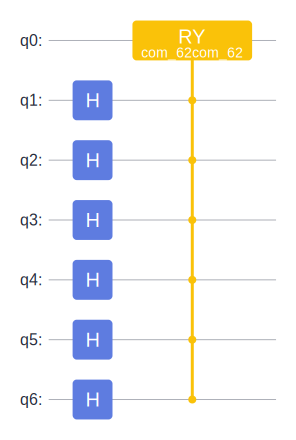

In [10]:
encoder = Circuit()

encoder += UN(H,range(1, com_qubits+1))
encoder += RY(2*com_parm[com_index]).on(0, range(1,com_qubits+1))
encoder.svg()

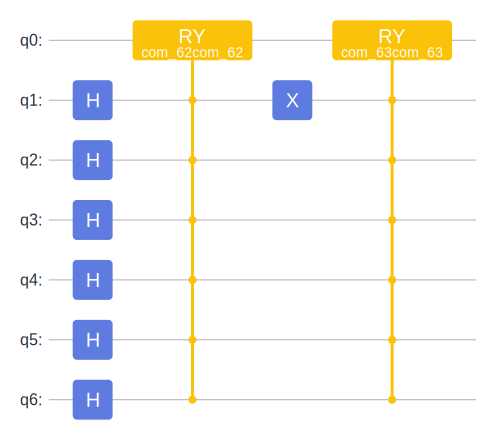

In [11]:
encoder += X.on(1)
com_index = com_index ^ (1 << (1-1))
encoder += RY(2*com_parm[com_index]).on(0, range(1,com_qubits+1))
encoder.svg()

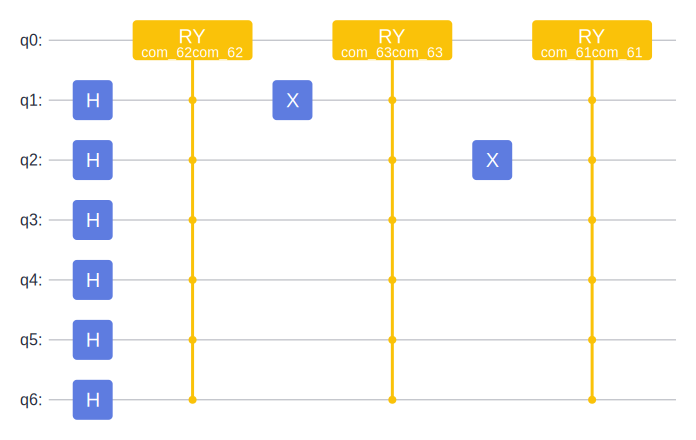

In [12]:
encoder += X.on(2)
com_index = com_index ^ (1 << (2-1))
encoder += RY(2*com_parm[com_index]).on(0, range(1,com_qubits+1))
encoder.svg()

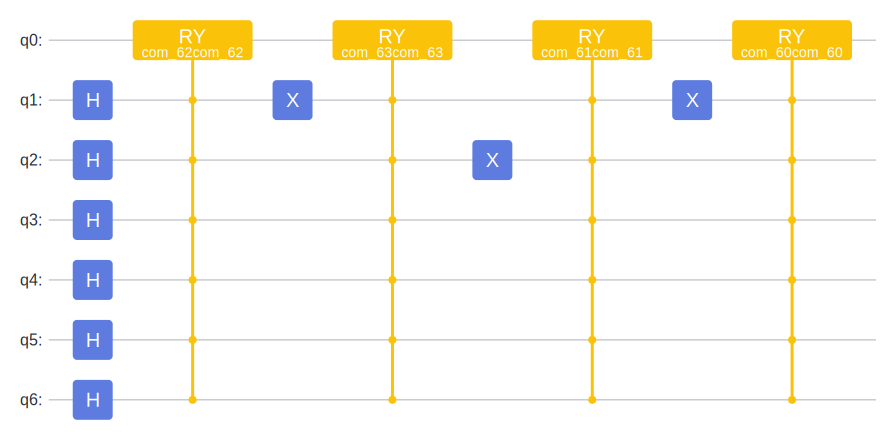

In [13]:
encoder += X.on(1)
com_index = com_index ^ (1 << (1-1))
encoder += RY(2*com_parm[com_index]).on(0, range(1,com_qubits+1))
encoder.svg()

In [38]:
img_height = 32
img_width = 32
img_channels = 2
img_total = img_height * img_width * img_channels
img_qubits = int(np.log2(img_height))*2      # 用于编码原始矩阵的量子比特数量

# network params
com_height = 8
com_width = 8                                       # 压缩后，矩阵的高和宽
com_qubits = int(np.log2(com_width))*2       # 用于编码压缩后矩阵的量子比特数量
anc_qubits = 1                                      # 用于 SAWP-TEST 的辅助量子比特
rec_qubits = img_qubits - com_qubits                # 用于恢复原始矩阵的增加的量子比特数量
total_qubits = anc_qubits + img_qubits

encoded_dim = com_height * com_width * img_channels
img_parm = [f'img_{i}' for i in range(2**img_qubits)]   # 用于编码原始矩阵数据的量子线路的参数
com_parm = [f'com_{i}' for i in range(2**com_qubits)]   # 用于编码压缩矩阵数据的量子线路的参数
img_index = 2**img_qubits-1                             # 用于指示当前对哪个数进行编码
com_index = 2**com_qubits-1
encoder = Circuit()

def cir_encoder(index):
    global com_index
    global com_parm
    global com_qubits
    global encoder
    if index == 1:
        encoder += X.on(1)
        com_index = com_index ^ 1
        encoder += RY(2*com_parm[com_index]).on(0, range(1, com_qubits+1))
    else:
        cir_encoder(index-1)
        encoder += X.on(index)
        com_index = com_index ^ (1 << (index-1))
        encoder += RY(2*com_parm[com_index]).on(0, range(1, com_qubits+1))
        cir_encoder(index-1)

cir_encoder(com_qubits)
encoder

┏━━━━━━━━━━━━━━━━━━┓       ┏━━━━━━━━━━━━━━━━━━┓                          
q0: ────────┨ RY(com_62com_62) ┠───────┨ RY(com_60com_60) ┠───────[red bold]↯[/]─                 
            ┗━━━━━━━━━┳━━━━━━━━┛       ┗━━━━━━━━━┳━━━━━━━━┛                          
      ┏━━━┓           ┃                          ┃          ┏━━━┓                    
q1: ──┨╺╋╸┠───────────■──────────────────────────■──────────┨╺╋╸┠─[red bold]↯[/]─                 
      ┗━━━┛           ┃                          ┃          ┗━━━┛                    
                      ┃          ┏━━━┓           ┃                                   
q2: ──────────────────■──────────┨╺╋╸┠───────────■────────────────[red bold]↯[/]─                 
                      ┃          ┗━━━┛           ┃                                   
                      ┃                          ┃                                   
q3: ──────────────────■──────────────────────────■────────────────[red bold]↯[/]─                 
                      ┃                          ┃                                   
                      ┃                          ┃                                   
q4: ──────────────────■──────────────────────────■────────────────[red bold]↯[/]─                 
                      ┃                          ┃                                   
                      ┃                          ┃                                   
q5: ──────────────────■──────────────────────────■────────────────[red bold]↯[/]─                 
                      ┃                          ┃                                   
                      ┃                          ┃                                   
q6: ──────────────────■──────────────────────────■────────────────[red bold]↯[/]─                 
                                                                                     
      ┏━━━━━━━━━━━━━━━━━━┓       ┏━━━━━━━━━━━━━━━━━━┓       ┏━━━━━━━━━━━━━━━━━━┓     
q0: ──┨ RY(com_61com_61) ┠───────┨ RY(com_57com_57) ┠───────┨ RY(com_56com_56) ┠─[red bold]↯[/]─  
      ┗━━━━━━━━━┳━━━━━━━━┛       ┗━━━━━━━━━┳━━━━━━━━┛       ┗━━━━━━━━━┳━━━━━━━━┛     
                ┃                          ┃          ┏━━━┓           ┃              
q1: ────────────■──────────────────────────■──────────┨╺╋╸┠───────────■──────────[red bold]↯[/]─  
                ┃                          ┃          ┗━━━┛           ┃              
                ┃                          ┃                          ┃              
q2: ────────────■──────────────────────────■──────────────────────────■──────────[red bold]↯[/]─  
                ┃                          ┃                          ┃              
                ┃          ┏━━━┓           ┃                          ┃              
q3: ────────────■──────────┨╺╋╸┠───────────■──────────────────────────■──────────[red bold]↯[/]─  
                ┃          ┗━━━┛           ┃                          ┃              
                ┃                          ┃                          ┃              
q4: ────────────■──────────────────────────■──────────────────────────■──────────[red bold]↯[/]─  
                ┃                          ┃                          ┃              
                ┃                          ┃                          ┃              
q5: ────────────■──────────────────────────■──────────────────────────■──────────[red bold]↯[/]─  
                ┃                          ┃                          ┃              
                ┃                          ┃                          ┃              
q6: ────────────■──────────────────────────■──────────────────────────■──────────[red bold]↯[/]─  
                                                                                     
            ┏━━━━━━━━━━━━━━━━━━┓       ┏━━━━━━━━━━━━━━━━━━┓                          
q0: ────────┨ RY(com_58com_58) ┠───────┨ RY(com_59com_59) ┠───────[red bold]↯[/]─                 
            ┗━━━━━━━━━┳━━━━━━━━┛ 

In [30]:
encoder.svg().to_file("quantum_circuit.fpg")

In [31]:
import cairosvg

In [32]:
svg_str = encoder.svg()
cairosvg.svg2png(bytestring=svg_str.encode('utf-8'), write_to="circuit.png")

AttributeError: 'SVGCircuit' object has no attribute 'encode'